## T2 DGOF Li, K., Gao, X., Jia, X., Xue, B., Fu, S., Liu, Z., Huang, X., & Huang, Z. (2022). Detection of local and clustered outliers based on the density–distance decision graph. Engineering Applications of Artificial Intelligence, 110, 104719. https://doi.org/10.1016/j.engappai.2022.104719

   Gender  Hemoglobin   MCH  MCHC   MCV  Result
0       1        14.9  22.7  29.1  83.7       0
1       0        15.9  25.4  28.3  72.0       0
2       0         9.0  21.5  29.6  71.2       1
3       0        14.9  16.0  31.4  87.5       0
4       1        14.7  22.0  28.2  99.5       0
AUC Value: 0.5049333494422295
Silhouette Score: 0.04047997312237937
Davies-Bouldin Index: 11.431014442476117
S/DB Ratio: 0.003541237561522601
Number of Outliers: 142
Percentage of Outliers: 9.99%
AUC Value: 0.5049333494422295


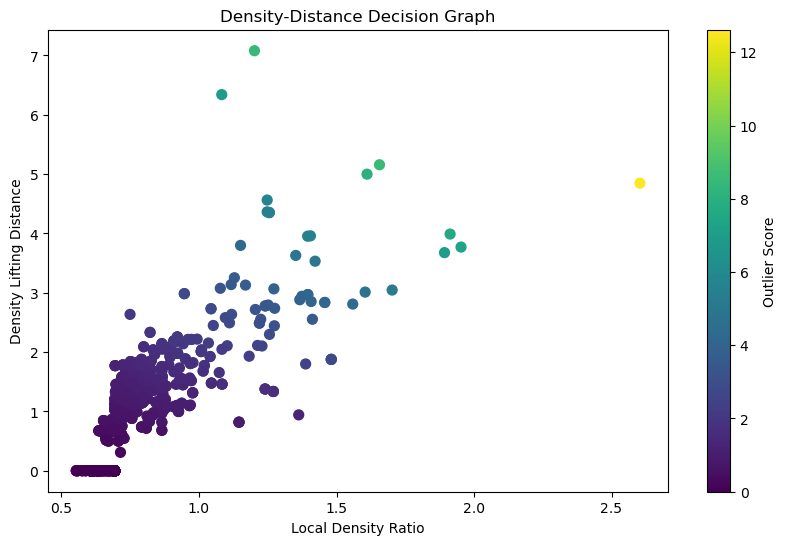

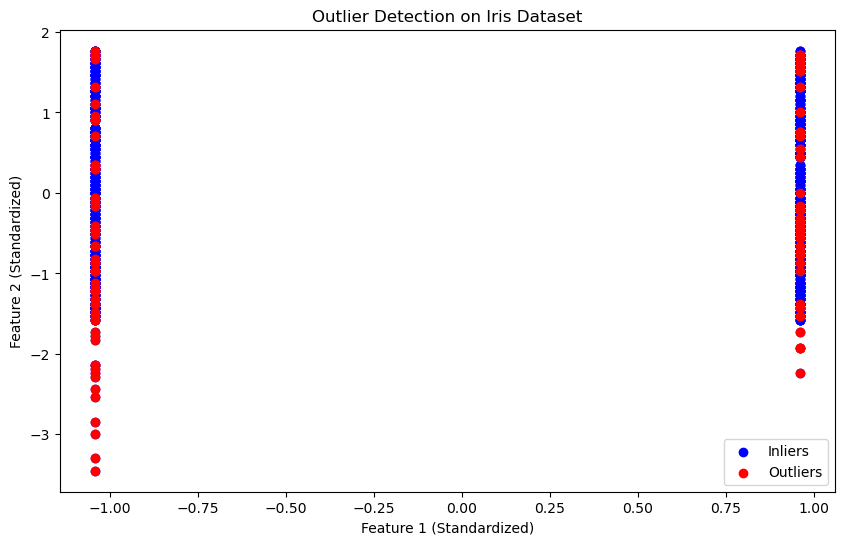

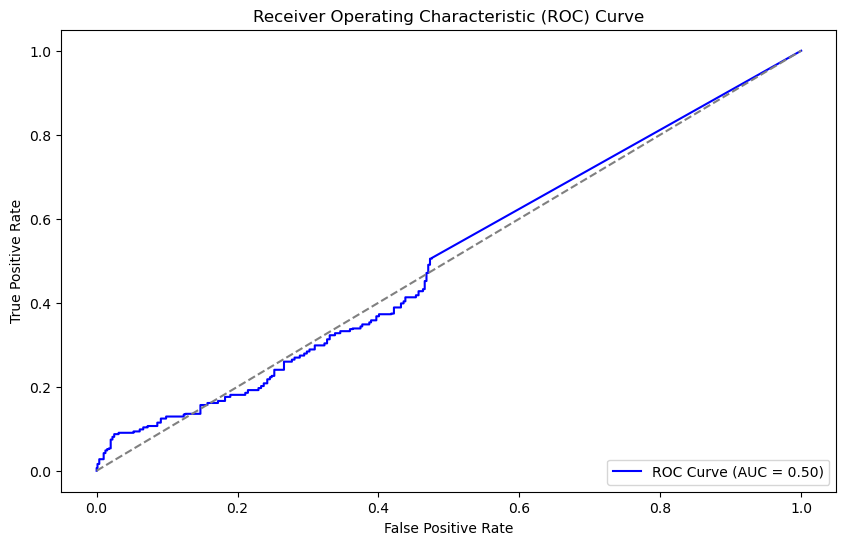

In [10]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Load and preprocess the Iris dataset
# Data = datasets.load_iris()
# X = Data.data
# y_true = Data.target  # Ground truth for ROC calculation
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

file_path = r"D:\Research Related\30 Deep Robust Clustering with Mahalanobis Distance (DRCMD)\dataset\anemia.csv"

# Load the dataset into a pandas DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Remove the last column
# Separate the features (X) and the target variable (y_true)
X = data.iloc[:, :-1]  # All columns except the last
y_true = data.iloc[:, -1]  # The last column
# If all columns are features:
#X = data

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Parameters
k = 5  # Number of neighbors

# Step 1: Calculate Local Reachable Kernel Density
def local_kernel_density(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    densities = 1 / (np.mean(distances[:, 1:], axis=1) + 1e-5)  # Avoid division by zero
    return densities, distances, indices

densities, distances, indices = local_kernel_density(X_scaled, k)

# Step 2: Compute Local Density Ratio and Density Lifting Distance
def compute_metrics(X, densities, indices, k):
    local_density_ratio = []
    density_lifting_distance = []
    for i, neighbors in enumerate(indices):
        neighbor_densities = densities[neighbors[1:]]  # Exclude self
        ratio = np.sum(neighbor_densities) / (len(neighbor_densities) * densities[i])
        local_density_ratio.append(np.log(ratio + 1))  # Log scaling
        lifting_distances = distances[i, 1:]  # Exclude self
        lifting_distances = lifting_distances[densities[neighbors[1:]] > densities[i]]
        lifting_distance = np.sum(lifting_distances) if len(lifting_distances) > 0 else 0
        density_lifting_distance.append(lifting_distance)
    return np.array(local_density_ratio), np.array(density_lifting_distance)

local_density_ratio, density_lifting_distance = compute_metrics(X_scaled, densities, indices, k)

# Step 3: Combine Metrics for Outlier Score
outlier_scores = local_density_ratio * density_lifting_distance

# Step 4: Evaluate Metrics
threshold = np.percentile(outlier_scores, 90)  # Top 10% as outliers
outliers = outlier_scores > threshold
outliers_count = np.sum(outliers)
outliers_percentage = 100 * outliers_count / len(X)

# Clustering metrics
silhouette = silhouette_score(X_scaled, outliers.astype(int))
davies_bouldin = davies_bouldin_score(X_scaled, outliers.astype(int))
s_db_ratio = silhouette / (davies_bouldin + 1e-5)  # Avoid division by zero

# ROC and AUC (for binary classification tasks)
# ROC and AUC (for binary classification tasks)
y_pred_scores = outlier_scores

# Ensure y_true contains two classes
assert len(np.unique(y_true)) > 1, "y_true must contain at least two classes for ROC AUC calculation."

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_scores)
roc_auc = roc_auc_score(y_true, y_pred_scores)

# Print AUC Value
print("AUC Value:", roc_auc)

# Print Metrics
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("S/DB Ratio:", s_db_ratio)
print("Number of Outliers:", outliers_count)
print("Percentage of Outliers:", f"{outliers_percentage:.2f}%")
print("AUC Value:", roc_auc)

# Step 5: Visualization of Density-Distance Decision Graph
plt.figure(figsize=(10, 6))
plt.scatter(local_density_ratio, density_lifting_distance, c=outlier_scores, cmap='viridis', s=50)
plt.colorbar(label='Outlier Score')
plt.title('Density-Distance Decision Graph')
plt.xlabel('Local Density Ratio')
plt.ylabel('Density Lifting Distance')
plt.show()

# Highlight Detected Outliers
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', label='Inliers')
plt.scatter(X_scaled[outliers, 0], X_scaled[outliers, 1], c='red', label='Outliers')
plt.title('Outlier Detection on Iris Dataset')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [9]:
y_true

0       0
1       0
2       1
3       0
4       0
       ..
1416    1
1417    1
1418    1
1419    0
1420    1
Name: Result, Length: 1421, dtype: int64

# 17/12/2024

Silhouette Score: 0.037
Davies-Bouldin Index: 9.016
S/DB Ratio: 0.004
Adjusted Rand Index (ARI): -0.026
F1-Score: 0.391
Hubness Score: 3.898
AUC Value: 0.478


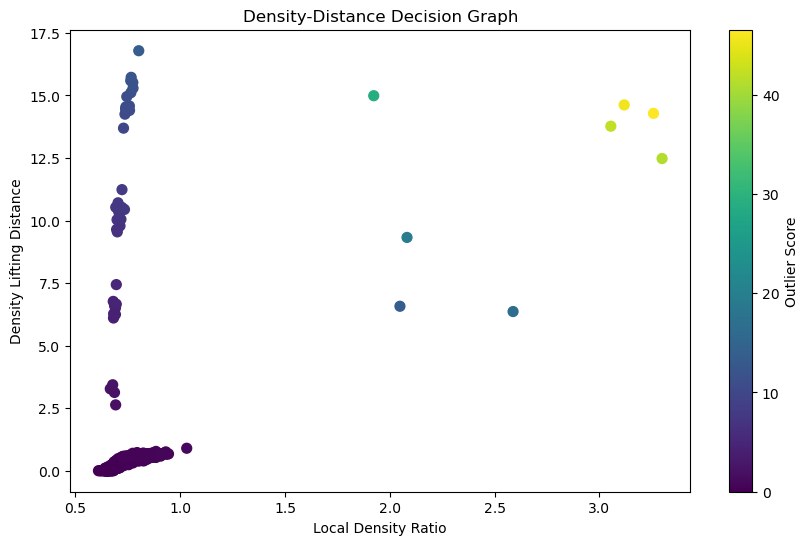

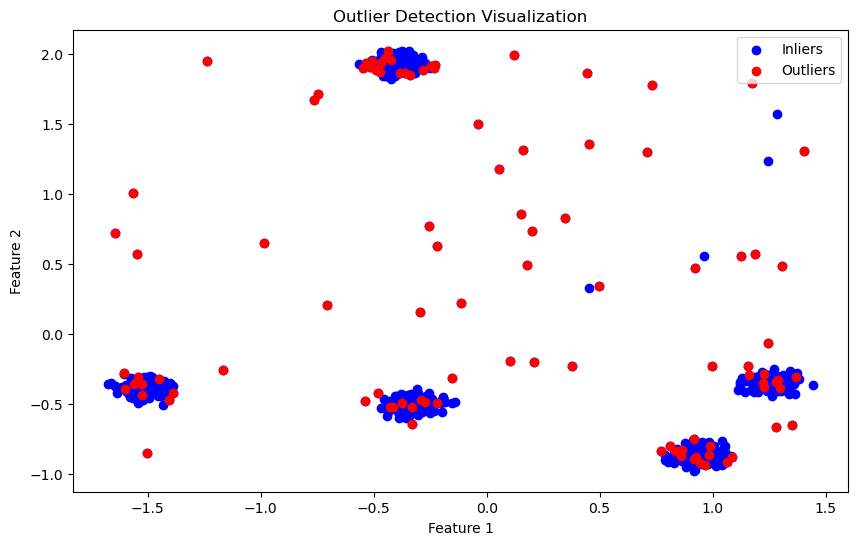

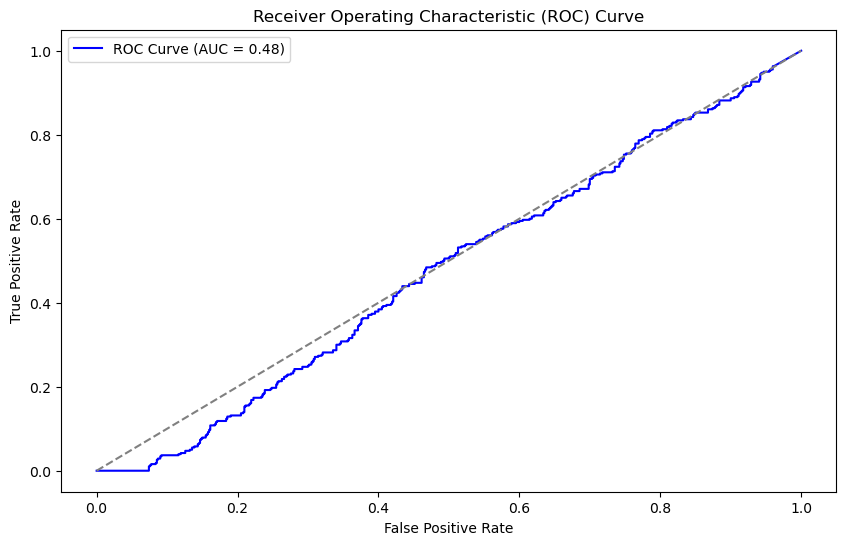

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, roc_auc_score, roc_curve,
    adjusted_rand_score, f1_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load the dataset
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\pima.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\parkinsons.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\heart.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\hepatitis.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\ionosphere.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\anemia.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn1.csv"
file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn2.csv"

data = pd.read_csv(file_path)

# Preprocess the data
X = data.iloc[:, :-1].values  # Features
y_true = data.iloc[:, -1].values  # Target variable (true labels)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
k = 5  # Number of neighbors

# Step 1: Local Reachable Kernel Density
def local_kernel_density(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    densities = 1 / (np.mean(distances[:, 1:], axis=1) + 1e-5)
    return densities, distances, indices

densities, distances, indices = local_kernel_density(X_scaled, k)

# Step 2: Local Density Ratio and Density Lifting Distance
def compute_metrics(X, densities, indices, k):
    local_density_ratio = []
    density_lifting_distance = []
    for i, neighbors in enumerate(indices):
        neighbor_densities = densities[neighbors[1:]]
        ratio = np.sum(neighbor_densities) / (len(neighbor_densities) * densities[i])
        local_density_ratio.append(np.log(ratio + 1))
        lifting_distances = distances[i, 1:][densities[neighbors[1:]] > densities[i]]
        lifting_distance = np.sum(lifting_distances) if len(lifting_distances) > 0 else 0
        density_lifting_distance.append(lifting_distance)
    return np.array(local_density_ratio), np.array(density_lifting_distance)

local_density_ratio, density_lifting_distance = compute_metrics(X_scaled, densities, indices, k)

# Step 3: Combine Metrics for Outlier Score
outlier_scores = local_density_ratio * density_lifting_distance

# Step 4: Evaluate Metrics
threshold = np.percentile(outlier_scores, 90)  # Top 10% as outliers
outliers = outlier_scores > threshold
outliers_count = np.sum(outliers)
outliers_percentage = 100 * outliers_count / len(X)

# Adjusted Rand Index (ARI)
predicted_labels = outliers.astype(int)
ari = adjusted_rand_score(y_true, predicted_labels)

# F1 Score
f1 = f1_score(y_true, predicted_labels, average="macro")

# Hubness Score
def hubness_score(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    hubness = np.bincount(indices.flatten(), minlength=len(X))
    return np.std(hubness)

hub_score = hubness_score(X_scaled, k)

# Clustering Metrics
silhouette = silhouette_score(X_scaled, predicted_labels)
davies_bouldin = davies_bouldin_score(X_scaled, predicted_labels)
s_db_ratio = silhouette / (davies_bouldin + 1e-5)  # Avoid division by zero

# ROC and AUC
fpr, tpr, _ = roc_curve(y_true, outlier_scores)
roc_auc = roc_auc_score(y_true, outlier_scores)

# # Print Metrics
# print("Silhouette Score:", silhouette)
# print("Davies-Bouldin Index:", davies_bouldin)
# print("S/DB Ratio:", s_db_ratio)
# print("Adjusted Rand Index (ARI):", ari)
# print("F1 Score:", f1)
# print("Hubness Score:", hub_score)
# print("Number of Outliers:", outliers_count)
# print("Percentage of Outliers:", f"{outliers_percentage:.2f}%")
# print("AUC Value:", roc_auc)

# Results
print("Silhouette Score:", np.round(silhouette,3))
print("Davies-Bouldin Index:", np.round(davies_bouldin,3))
print("S/DB Ratio:", np.round(s_db_ratio,3))
print("Adjusted Rand Index (ARI):", np.round(ari,3))
print("F1-Score:", np.round(f1,3))
print("Hubness Score:", np.round(hub_score,3))
print("AUC Value:", np.round(roc_auc,3))

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(local_density_ratio, density_lifting_distance, c=outlier_scores, cmap='viridis', s=50)
plt.colorbar(label='Outlier Score')
plt.title('Density-Distance Decision Graph')
plt.xlabel('Local Density Ratio')
plt.ylabel('Density Lifting Distance')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', label='Inliers')
plt.scatter(X_scaled[outliers, 0], X_scaled[outliers, 1], c='red', label='Outliers')
plt.title('Outlier Detection Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
